In [1]:
using LinearAlgebra, Random, Distributions
using Images, Plots
using Interpolations

zone_lowres = load("/Users/joshuaott/Downloads/nobile/other/zone-map.tif")
zone_color = load("/Users/joshuaott/Downloads/nobile/zone-map_high_res.png")
zone = load("/Users/joshuaott/Downloads/nobile/ice_stability_depth.tiff")
zone_map_color = zone_color[1650:1750, 1200:1250] 
zone_map = zone[1650:1750, 1200:1250] 
zone_map_values = Float64.(zone_map)
zone_map_rewards = (-1 .* zone_map_values .+ 1) .* 3;

┌ Warning: QuartzImageIO: indexed color images not implemented
└ @ QuartzImageIO /Users/joshuaott/.julia/packages/QuartzImageIO/hnNSo/src/QuartzImageIO.jl:65


In [6]:
mutable struct GaussianProcess
    m # mean
    k # covariance function
    X # design points
    y # objective values
    ν # noise variance
    A # K(Xq, Xq) this will always be the same (our query points do not change)
    # B # K(X, X) 
    # C # K(Xq, X)
end

mutable struct TwoDGaussianProcess
    m::Vector{Float64} # mean
    k # covariance function
    X # design points
    y # objective values
    ν # noise variance
    A # K(Xq, Xq) this will always be the same (our query points do not change)
    # B # K(X, X) 
    # C # K(Xq, X)
end



μ(X, m) = [m(x) for x in X]
# μ(X::Vector{Int64}, m) = reshape([m(x) for x in X][1], length(X))
# μ(X::Vector{Vector{Int64}}, m) = reshape([m(x) for x in X][1], length(X))
# μ(X, m::Interpolations.Extrapolation{Float64, 2, ScaledInterpolation{Float64, 2, Interpolations.BSplineInterpolation{Float64, 2, Matrix{Float64}, BSpline{Linear{Throw{OnGrid}}}, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}, BSpline{Linear{Throw{OnGrid}}}, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}, BSpline{Linear{Throw{OnGrid}}}, Throw{Nothing}}) = reshape([m(x) for x in X][1], length(X))

Σ(X, k) = [k(x,x′) for x in X, x′ in X]
K(X, X′, k) = [k(x,x′) for x in X, x′ in X′]
# ν(X, K) = [variance(x, X, K) for x in X]

function mvnrand(μ, Σ, inflation=1e-6)
    N = MvNormal(μ, Σ + inflation*I)
    #N = MvNormal(μ, Σ)
    return rand(N)
end
Base.rand(GP, X) = mvnrand(μ(X, GP.m), Σ(X, GP.k))
Base.rand(GP, μ_calc, Σ_calc) = mvnrand(μ_calc, Σ_calc)

In [7]:
function query1(GP, X_query)
    m, k, ν = GP.m, GP.k, GP.ν
    tmp = K(X_query, GP.X, k) / (K(GP.X, GP.X, k) + diagm(GP.ν))
    μₚ = μ(X_query, m) + tmp*(GP.y - μ(GP.X, m))
    S = K(X_query, X_query, k) - tmp*K(GP.X, X_query, k)
    νₚ = diag(S) .+ eps() # eps prevents numerical issues
    return (μₚ, νₚ, S)
end

function query_no_data(GP, X_query)
    m, k = GP.m, GP.k
    μₚ = μ(X_query, m)
    S = K(X_query, X_query, k)
    νₚ = diag(S) .+ eps() # eps prevents numerical issues
    return (μₚ, νₚ)
end



# function query2(GP, X_query::Vector{Int64})
#     m, k, ν = GP.m, GP.k, GP.ν
    
#     KXqXq = GP.A[1:length(X_query), 1:length(X_query)]
#     KXqX = [KXqXq  GP.A[(length(X_query)+1):end, 1:end-(length(GP.X) - length(X_query))]']
#     KXX = GP.A
    
#     # I think we can make this even faster by storing the result of tmp to prevent having to repeat matrix inversion
#     tmp = KXqX / (KXX + diagm(GP.ν))
#     μₚ = μ(X_query, m) + tmp*(GP.y - μ(GP.X, m))
#     S = KXqXq - tmp*KXqX'
#     νₚ = diag(S) .+ eps() # eps prevents numerical issues
#     return (μₚ, νₚ)
# end

# function query2(GP, X_query::Vector{Vector{Int64}})
#     m, k, ν = GP.m, GP.k, GP.ν
    
#     KXqXq = GP.A[1:length(X_query), 1:length(X_query)]
#     KXqX = [KXqXq  GP.A[(length(X_query)+1):end, 1:end-(length(GP.X) - length(X_query))]']
#     KXX = GP.A
    
#     # I think we can make this even faster by storing the result of tmp to prevent having to repeat matrix inversion
#     tmp = KXqX / (KXX + diagm(GP.ν))
#     μₚ = μ(X_query, m) + tmp*(GP.y - μ(GP.X, m))
#     S = KXqXq - tmp*KXqX'
#     νₚ = diag(S) .+ eps() # eps prevents numerical issues
#     return (μₚ, νₚ)
# end

function query2(GP, X_query)
    m, k, ν = GP.m, GP.k, GP.ν
    
    KXqXq = GP.A[1:length(X_query), 1:length(X_query)]
    KXqX = [KXqXq  GP.A[(length(X_query)+1):end, 1:end-(length(GP.X) - length(X_query))]']
    KXX = GP.A
    
    # I think we can make this even faster by storing the result of tmp to prevent having to repeat matrix inversion
    tmp = KXqX / (KXX + diagm(GP.ν))
    μₚ = μ(X_query, m) + tmp*(GP.y - μ(GP.X, m))
    S = KXqXq - tmp*KXqX'
    νₚ = diag(S) .+ eps() # eps prevents numerical issues
    return (μₚ, νₚ)
end

function query_post(GP, X_query)
    m, k, ν = GP.m, GP.k, GP.ν
    
    KXqXq = GP.A[1:length(X_query), 1:length(X_query)]
    KXqX = [KXqXq  GP.A[(length(X_query)+1):end, 1:end-(length(GP.X) - length(X_query))]']
    KXX = GP.A
    
    # I think we can make this even faster by storing the result of tmp to prevent having to repeat matrix inversion
    tmp = KXqX / (KXX + diagm(GP.ν))
    μₚ = GP.m(X_query) + tmp*(GP.y - GP.m(GP.X))
    S = KXqXq - tmp*KXqX'
    νₚ = diag(S) .+ eps() # eps prevents numerical issues
    return (μₚ, νₚ)
end


function twoDposterior(GP, X_samp, y_samp, ν_samp, X_query)
    a = K(GP.X, X_samp, k) # K(X, X) 
    A = [GP.A a; a' I]
    ν = vcat(GP.ν, ν_samp)
    new_y = vcat(GP.y, y_samp)
    new_X = vcat(GP.X, X_samp)
    
    
    idx = findall(x->x==X_samp, GP.X)
    new_mean = GP.m + A[1:5151, 1:length(new_y)] / (A + diagm(ν))*(new_y - vcat(GP.m, GP.m[idx]))

    return GaussianProcess(m_post, GP.k, [GP.X; X_samp], [GP.y; y_samp], [GP.ν; ν_samp], A)
end

    

function posterior(GP, X_samp, y_samp, ν_samp)
    # if this is the first data we have seen, we need to update mean and covariance of GP
    # TODO: maybe GP.X should be initialized as static array for better performance??
    if GP.X == []
        A = [GP.k(x,x′) for x in X_samp, x′ in X_samp] + ν_samp*I
        m_post = (X-> ([GP.m(X)] + ([GP.k(x,x′) for x in X, x′ in X_samp] / A)*[(y_samp - GP.m(X_samp))])[1])
            
        return GaussianProcess(m_post, GP.k, X_samp, [y_samp], ν_samp, A)

    else
        # KXqXq = GP.A[1:length(X_query), 1:length(X_query)]
        # KXqX = [KXqXq  GP.A[(length(X_query)+1):end, 1:end-(length(GP.X) - length(X_query))]']
        # KXX = GP.A

        # tmp = KXqX / (KXX + diagm(GP.ν))


        # m_post = (X-> (GP.m(x) + KXqX / GP.A)*(y_samp - GP.m(x)))
        if typeof(X_samp) == Vector{Float64}
            m_post = (X->query2(GP,X)[1][1]) # I don't think this will work! 
        else
            #m_post = (X->query2(GP,X)[1]) # I don't think this will work!
            m_post = query_post(GP, X)
        end
        a = K(GP.X, X_samp, k) # K(X, X) 
        A = [GP.A a; a' I]
        
            
        return GaussianProcess(m_post, GP.k, [GP.X; X_samp], [GP.y; y_samp], [GP.ν; ν_samp], A)
    end

    
    # TODO: also need to implement rand, pdf, mean, mode, etc.!
    
    
end

function plot(GP::GaussianProcess, x_plot)
   if GP.y == []
        (m_plot, ν_plot)  = query_no_data(GP, x_plot)
        Plots.plot(x_plot, m_plot, ribbons=3 .* ν_plot, color=:blue, fillalpha=0.2, linewidth=2, legend=false)
    else
        (m_plot, ν_plot)  = query1(GP, x_plot)
        Plots.plot(x_plot, m_plot, ribbons=3 .* ν_plot, color=:blue, fillalpha=0.2, linewidth=2, legend=false)
        scatter!(GP.X, GP.y, color=:red)
    end
end

plot (generic function with 1 method)

# 2D Testing

In [52]:
# Interpolation
y = range(1, size(zone_map_values)[2], length=size(zone_map_values)[2])
x = range(1, size(zone_map_values)[1], length=size(zone_map_values)[1])
z = zone_map_values
# Interpolatant object
@time itp = LinearInterpolation((x, y), z);


L=10
k(x,x′) = exp(-(transpose(x-x′)*(x-x′)) / (2*L^2))#exp(-(x-x′)^2 / (2*L^2)) #kernel function
m(x) = itp(x[1], x[2])

X = [[i,j] for i = 1:size(zone_map_values)[1], j = 1:size(zone_map_values)[2]]
X = reshape(X, 5151)
A = K(X, X, k)
#GP = GaussianProcess(m, k, X, reshape(zone_map_values, 5151), 0.2*ones(length(X)), A)

GP = TwoDGaussianProcess(μ(X, m), k, X, reshape(zone_map_values, 5151), 0.2*ones(length(X)), A)

  0.000019 seconds (4 allocations: 40.531 KiB)


TwoDGaussianProcess([1.0, 0.8806897077897307, 0.866803997863737, 0.866803997863737, 0.8887769893949797, 0.8058594644083314, 0.7995880064087892, 0.7995880064087892, 0.7736934462500954, 1.0  …  0.6397344930189974, 0.6369268329900053, 0.9428702220187686, 1.0, 1.0, 1.0, 0.8305943389028764, 0.6918593118181124, 0.683085374227512, 0.6825055313954376], k, [[1, 1], [2, 1], [3, 1], [4, 1], [5, 1], [6, 1], [7, 1], [8, 1], [9, 1], [10, 1]  …  [92, 51], [93, 51], [94, 51], [95, 51], [96, 51], [97, 51], [98, 51], [99, 51], [100, 51], [101, 51]], [1.0, 0.8806897077897307, 0.866803997863737, 0.866803997863737, 0.8887769893949797, 0.8058594644083314, 0.7995880064087892, 0.7995880064087892, 0.7736934462500954, 1.0  …  0.6397344930189974, 0.6369268329900053, 0.9428702220187686, 1.0, 1.0, 1.0, 0.8305943389028764, 0.6918593118181124, 0.683085374227512, 0.6825055313954376], [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2  …  0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2], [1.0 0.9950124791926823 … 1.94

In [51]:

X_samp = [[2,2]]
y_samp = 0.5
ν_samp = 0.2

k₁ = SqExponentialKernel()
K₁ = kernelmatrix(k₁, X)

a = K(GP.X, X_samp, k) # K(X, X) 
A = [GP.A a; a' I]
ν = vcat(GP.ν, ν_samp)
new_y = vcat(GP.y, y_samp)
new_X = vcat(GP.X, X_samp)


idx = findall(x->x==X_samp[1], GP.X)
new_mean = GP.m + A[1:5151, 1:length(new_y)] *inv(A + diagm(ν))*(new_y - vcat(GP.m, GP.m[idx]))


#invA = (A + diagm(ν))

#[GP.y, y_samp] #- [GP.m, GP.m[idx]]
#vcat(GP.m, GP.m[idx])

  4.066546 seconds (25 allocations: 812.744 MiB, 1.89% gc time)


5151-element Vector{Float64}:
 0.9789058683459801
 0.862553224734109
 0.8516692233587007
 0.854604240010336
 0.8793443532754304
 0.798940473663551
 0.7948639342094319
 0.7966981681126613
 0.7722594982069896
 0.9996492785317301
 0.8442252890162644
 0.8267138406401225
 0.8268973418278684
 ⋮
 0.7574889826907936
 0.6830402577568014
 0.6397351121469051
 0.6369273414173559
 0.9428705721771491
 1.0000001696367773
 0.99999999286812
 0.9999998438210456
 0.8305940810909408
 0.6918590136246412
 0.6830851040504832
 0.6825053579924342

In [58]:
using KernelFunctions

k₁ = SqExponentialKernel()
@time K₁ = kernelmatrix(k₁, X)
@time inv(K₁)

  0.804692 seconds (6 allocations: 404.859 MiB)
 28.486276 seconds (6 allocations: 204.984 MiB)


5151×5151 Matrix{Float64}:
  3.93007      -3.77097       2.6452       …  -2.74575e-32   1.05272e-32
 -3.77097       7.54839      -6.30909          7.16158e-32  -2.74575e-32
  2.6452       -6.30909       9.32878         -1.36555e-31   5.23554e-32
 -1.68846       4.2653       -7.44553          2.36938e-31  -9.08422e-32
  1.04321      -2.68943       4.96745         -3.97933e-31   1.52568e-31
 -0.63703       1.65445      -3.1182       …   6.60532e-31  -2.53248e-31
  0.387338     -1.00869       1.91515         -1.09174e-30   4.18573e-31
 -0.235147      0.612966     -1.16696          1.80162e-30  -6.9074e-31
  0.142672     -0.372043      0.708994        -2.97136e-30   1.13922e-30
 -0.0865455     0.225714     -0.430294         4.89955e-30  -1.87849e-30
  0.0524949    -0.136915      0.261046     …  -8.07835e-30   3.09724e-30
 -0.0318403     0.0830462    -0.158346         1.33192e-29  -5.10658e-30
  0.0193122    -0.0503707     0.0960446       -2.19597e-29   8.41938e-30
  ⋮                      

In [6]:
@time (μ2ₚ, ν2ₚ) = query2(GP,X)

 11.178474 seconds (7.28 M allocations: 2.146 GiB, 1.39% gc time, 20.58% compilation time)


([1.0, 0.8806897077897307, 0.866803997863737, 0.866803997863737, 0.8887769893949797, 0.8058594644083314, 0.7995880064087892, 0.7995880064087892, 0.7736934462500954, 1.0  …  0.6397344930189974, 0.6369268329900053, 0.9428702220187686, 1.0, 1.0, 1.0, 0.8305943389028764, 0.6918593118181124, 0.683085374227512, 0.6825055313954376], [0.02272982200010687, 0.01634904590224384, 0.012744883468815416, 0.01087683858311761, 0.00998033184636038, 0.009556080710504289, 0.009322180639401711, 0.009149257817862577, 0.00899703660438711, 0.008864660069195951  …  0.008864660069195396, 0.00899703660438722, 0.009149257817863576, 0.00932218063940149, 0.0095560807105044, 0.009980331846360713, 0.010876838583117054, 0.012744883468815194, 0.016349045902243953, 0.02272982200010698])

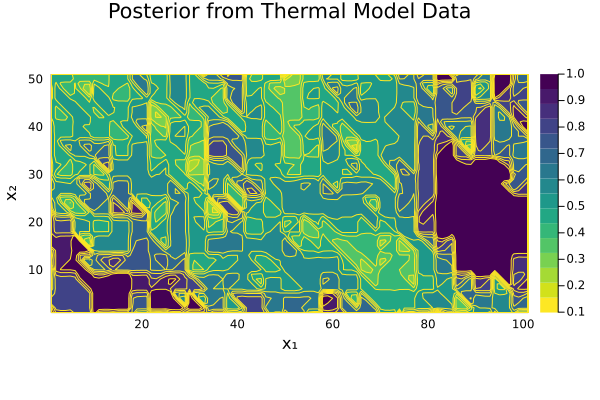

In [28]:
contourf(reshape(μ2ₚ, (101,51))', title="Posterior from Thermal Model Data" ,colorbar = true, c = cgrad(:viridis, rev = true), xlims = (1, 101), ylims = (1, 51),legend = true,  xlabel = "x₁", ylabel = "x₂", aspectratio = :equal)

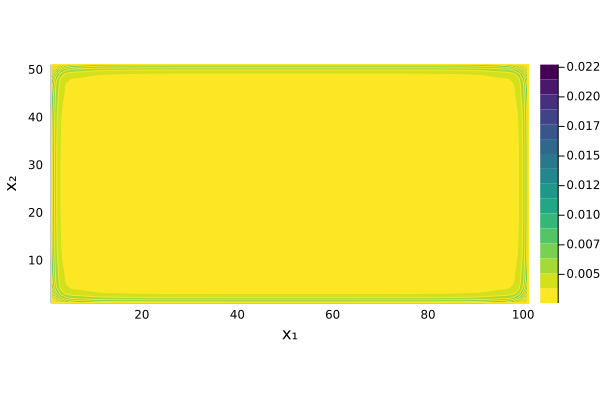

In [29]:
contourf(reshape(ν2ₚ, (101,51))',colorbar = true, c = cgrad(:viridis, rev = true), xlims = (1, 101), ylims = (1, 51),legend = true,  xlabel = "x₁", ylabel = "x₂", aspectratio = :equal)

In [35]:
# (μ_postₚ, ν_postₚ) = query_post(post_GP, X)
X_query = X
KXqXq = post_GP.A[1:length(X_query), 1:length(X_query)]
KXqX = [KXqXq  post_GP.A[(length(X_query)+1):end, 1:end-(length(post_GP.X) - length(X_query))]']
KXX = post_GP.A

tmp = KXqX / (KXX + diagm(post_GP.ν))
# μₚ = post_GP.m(X_query) + tmp*(post_GP.y - post_GP.m(post_GP.X))
# S = KXqXq - tmp*KXqX'
# νₚ = diag(S) .+ eps() # eps prevents numerical issues

5151×5152 Matrix{Float64}:
  0.113649     0.0934886     0.0743346   …  -7.13268e-7  -0.000366929
  0.0934886    0.0817451     0.0696519       6.43128e-7  -0.000283388
  0.0743346    0.0696519     0.0637244       1.58646e-6  -0.000200354
  0.0567612    0.0576499     0.0568259       2.05741e-6  -0.000120318
  0.0412137    0.046151      0.0492753       2.03737e-6  -4.54538e-5
  0.0279889    0.0355136     0.0414146   …   1.55408e-6   2.24837e-5
  0.0172277    0.0260224     0.033585        6.83027e-7   8.22239e-5
  0.00892031   0.0178758     0.0261036      -4.56109e-7   0.000133005
  0.00292263   0.0111795     0.0192429      -1.70828e-6   0.000174558
 -0.00101815   0.00594805    0.0132149      -2.89682e-6   0.000207049
 -0.00323172   0.00211317    0.00816041  …  -3.84112e-6   0.000231003
 -0.00409008  -0.000461808   0.00414566     -4.37679e-6   0.000247203
 -0.00397359  -0.00196383    0.00116468     -4.37615e-6   0.00025659
  ⋮                                      ⋱   ⋮           
 -4.38146

In [44]:

post_GP.m(post_GP.X)

LoadError: BoundsError: attempt to access 5151×5151 Matrix{Float64} at index [1:5152, 1:5152]

In [8]:
@time post_GP = posterior(GP, [[30, 30]], 0.5, [0.2])
#query2(post_GP, X)
# plot(post_GP, collect(1:0.1:10))

  0.882517 seconds (1.56 M allocations: 288.027 MiB, 75.02% compilation time)


GaussianProcess(var"#11#16"{GaussianProcess}(GaussianProcess(m, k, [[1, 1], [2, 1], [3, 1], [4, 1], [5, 1], [6, 1], [7, 1], [8, 1], [9, 1], [10, 1]  …  [92, 51], [93, 51], [94, 51], [95, 51], [96, 51], [97, 51], [98, 51], [99, 51], [100, 51], [101, 51]], [1.0, 0.8806897077897307, 0.866803997863737, 0.866803997863737, 0.8887769893949797, 0.8058594644083314, 0.7995880064087892, 0.7995880064087892, 0.7736934462500954, 1.0  …  0.6397344930189974, 0.6369268329900053, 0.9428702220187686, 1.0, 1.0, 1.0, 0.8305943389028764, 0.6918593118181124, 0.683085374227512, 0.6825055313954376], [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2  …  0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2], [1.0 0.9950124791926823 … 1.9440968229442156e-27 7.187781739060989e-28; 0.9950124791926823 1.0 … 5.2059255769452236e-27 1.9440968229442156e-27; … ; 1.9440968229442156e-27 5.2059255769452236e-27 … 1.0 0.9950124791926823; 7.187781739060989e-28 1.9440968229442156e-27 … 0.9950124791926823 1.0])), k, [[1, 1], [2, 1],

In [24]:
#query2(post_GP, X)
post_GP.m([[30,30]])


@time post_GP.m(X)

#[post_GP.m(x) for x in X]
#μ(X, post_GP.m)
# X_query = X
# KXqXq = post_GP.A[1:length(X_query), 1:length(X_query)]
# KXqX = [KXqXq  GP.A[(length(X_query)+1):end, 1:end-(length(GP.X) - length(X_query))]']
# KXX = GP.A

# # I think we can make this even faster by storing the result of tmp to prevent having to repeat matrix inversion
# tmp = KXqX / (KXX + diagm(GP.ν))
# μₚ = μ(X_query, m) + tmp*(GP.y - μ(GP.X, m))
# S = KXqXq - tmp*KXqX'
# νₚ = diag(S) .+ eps() # eps prevents numerical issues
# return (μₚ, νₚ)

  9.414652 seconds (10.36 k allocations: 1.780 GiB, 0.78% gc time)


5151-element Vector{Float64}:
 1.0
 0.8806897077897307
 0.866803997863737
 0.866803997863737
 0.8887769893949797
 0.8058594644083314
 0.7995880064087892
 0.7995880064087892
 0.7736934462500954
 1.0
 0.8438391699092088
 0.8258945601586938
 0.8258945601586938
 ⋮
 0.7574883649958037
 0.6830395971618219
 0.6397344930189974
 0.6369268329900053
 0.9428702220187686
 1.0
 1.0
 1.0
 0.8305943389028764
 0.6918593118181124
 0.683085374227512
 0.6825055313954376

In [27]:
X

5151-element Vector{Vector{Int64}}:
 [1, 1]
 [2, 1]
 [3, 1]
 [4, 1]
 [5, 1]
 [6, 1]
 [7, 1]
 [8, 1]
 [9, 1]
 [10, 1]
 [11, 1]
 [12, 1]
 [13, 1]
 ⋮
 [90, 51]
 [91, 51]
 [92, 51]
 [93, 51]
 [94, 51]
 [95, 51]
 [96, 51]
 [97, 51]
 [98, 51]
 [99, 51]
 [100, 51]
 [101, 51]

In [79]:
X_query = X
# KXqXq = post_GP.A[1:length(X_query), 1:length(X_query)]
# KXqX = [KXqXq  post_GP.A[(length(X_query)+1):end, 1:end-(length(post_GP.X) - length(X_query))]']
# KXX = post_GP.A

# # I think we can make this even faster by storing the result of tmp to prevent having to repeat matrix inversion
#tmp = KXqX / (KXX + diagm(post_GP.ν))
#μₚ = μ(X_query, post_GP.m) + tmp*(post_GP.y - μ(post_GP.X, post_GP.m))
# S = KXqXq - tmp*KXqX'
# νₚ = diag(S) .+ eps() # eps prevents numerical issues
# return (μₚ, νₚ)

#μ(X_query, post_GP.m)
#post_GP.m(X[1])
#reshape([post_GP.m(x) for x in X][1], length(X))
#μ(X_query, post_GP.m)
#query2(GP, X_query)[1]
typeof(post_GP.m) == var"#55#60"{GaussianProcess}
#query2(GP, [1,1])#post_GP.m([1,1])
#μ([[1,1]], GP.m)
[GP.m(x) for x in [[1,1]]]
itp(1,1)

# THERE IS AN ISSUE WITH YOU SWITCHING BETWEEN M([1,1]) AND ITP(1,1)
# NEXT STEPS: CAN WE SWITCH OVER TO INITALIZING MEAN WITHOUT KEEPING AROUND THE 5151 POINTS? IF SO THIS SHOULD BE ALOT FASTER

1.0

In [53]:
#μ([1,1], post_GP.m)
#query2(GP,[[1,1]])
typeof([1,1])

Vector{Int64} (alias for Array{Int64, 1})

In [62]:
μ([[1,1]], post_GP.m)

LoadError: BoundsError

# 1D Testing

In [45]:
using SpecialFunctions

# lets test out a 1d example to make sure everything is working like we expect


L= 3.0
v = 0.5
ℓ = 1.0

k(x,x′) = exp(-(transpose(x-x′)*(x-x′)) / (2.0*L^2)) #+ ((2.0^(1-v))/gamma(v))*((sqrt(2.0*v)*(x-x′)/ℓ)^v)*besselk(v, (sqrt(2.0*v)*(x-x′)/ℓ))
m(x) = 0.0

# #X = float(collect(1:10))
# A = K(X, X, k)
GP = GaussianProcess(m, k, [], [], [], [])

GaussianProcess(m, k, Any[], Any[], Any[], Any[])

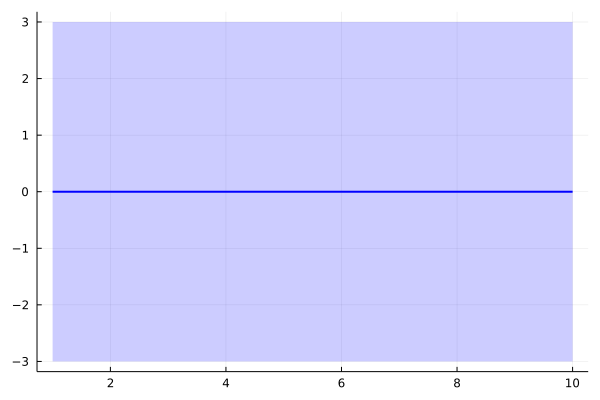

In [46]:
plot(GP, collect(1:0.1:10))

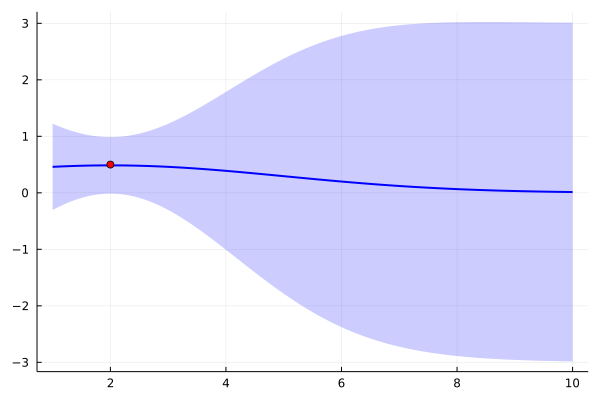

In [47]:
post_GP = posterior(GP, [2.0], 0.5, [0.2])
query1(post_GP, collect(1:0.1:10))
plot(post_GP, collect(1:0.1:10))

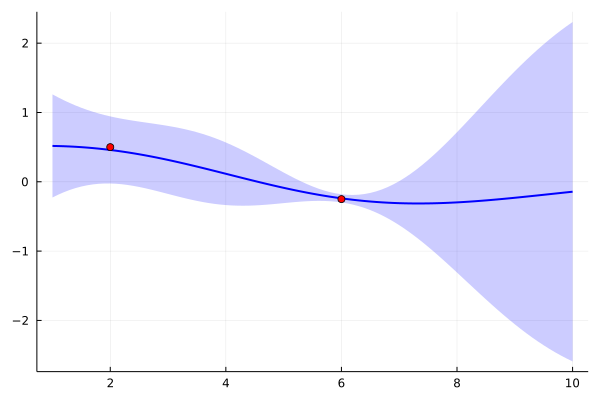

In [48]:
post_post_GP = posterior(post_GP, [6.0], -0.25, [0.02])
μ(collect(1:0.1:10), post_post_GP.m)
query1(post_post_GP, collect(1:0.1:10))
plot(post_post_GP, collect(1:0.1:10))

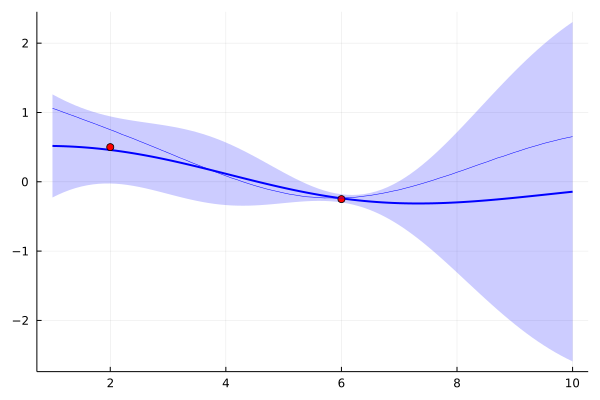

In [49]:
# PLOT WITH SAMPLES
(m_plot, ν_plot, S)  = query1(post_post_GP, collect(1:0.1:10))
Plots.plot!(collect(1:0.1:10), rand(post_post_GP, m_plot, Matrix(Hermitian(S))), color=:blue, linewidth=0.5)

In [48]:
typeof([2.0])

Vector{Float64} (alias for Array{Float64, 1})

In [63]:
besselk(v, (sqrt(2.0*v)*(x-x′)/ℓ))

Inf

In [65]:
using KernelFunctions
Matern32Kernel()

┌ Info: Precompiling KernelFunctions [ec8451be-7e33-11e9-00cf-bbf324bd1392]
└ @ Base loading.jl:1423


Matern 3/2 Kernel (metric = Euclidean(0.0))

In [44]:
#X_query = X
#GP_post = posterior(GP, [[1,1]], 0.1, 0.02)

@time (μ1ₚ, ν1ₚ) = query1(GP,X)

#[GP.A[1:length(X_query), 1:length(X_query)]  GP.A[length(X_query):end, 1:end-1]]
# GP.A[length(X_query):end, :]
# length(X_query)

 37.372584 seconds (506.39 M allocations: 22.374 GiB, 8.62% gc time, 0.09% compilation time)


([1.0, 0.8806897077897307, 0.866803997863737, 0.866803997863737, 0.8887769893949797, 0.8058594644083314, 0.7995880064087892, 0.7995880064087892, 0.7736934462500954, 1.0  …  0.6397344930189974, 0.6369268329900053, 0.9428702220187686, 1.0, 1.0, 1.0, 0.8305943389028764, 0.6918593118181124, 0.683085374227512, 0.6825055313954376], [0.02272982200010687, 0.01634904590224384, 0.012744883468815416, 0.01087683858311761, 0.00998033184636038, 0.009556080710504289, 0.009322180639401711, 0.009149257817862577, 0.00899703660438711, 0.008864660069195951  …  0.008864660069195396, 0.00899703660438722, 0.009149257817863576, 0.00932218063940149, 0.0095560807105044, 0.009980331846360713, 0.010876838583117054, 0.012744883468815194, 0.016349045902243953, 0.02272982200010698])

In [43]:
@time (μ2ₚ, ν2ₚ) = query2(GP,X)
#GP.ν = rand(5151)



 13.154885 seconds (108 allocations: 1.781 GiB, 1.53% gc time, 0.07% compilation time)


([1.0, 0.8806897077897307, 0.866803997863737, 0.866803997863737, 0.8887769893949797, 0.8058594644083314, 0.7995880064087892, 0.7995880064087892, 0.7736934462500954, 1.0  …  0.6397344930189974, 0.6369268329900053, 0.9428702220187686, 1.0, 1.0, 1.0, 0.8305943389028764, 0.6918593118181124, 0.683085374227512, 0.6825055313954376], [0.02272982200010687, 0.01634904590224384, 0.012744883468815416, 0.01087683858311761, 0.00998033184636038, 0.009556080710504289, 0.009322180639401711, 0.009149257817862577, 0.00899703660438711, 0.008864660069195951  …  0.008864660069195396, 0.00899703660438722, 0.009149257817863576, 0.00932218063940149, 0.0095560807105044, 0.009980331846360713, 0.010876838583117054, 0.012744883468815194, 0.016349045902243953, 0.02272982200010698])

In [80]:
typeof(m)

LoadError: UndefVarError: singleton not defined

In [38]:
@time (μₚ, νₚ) = query(GP, X)

 32.418098 seconds (512.07 M allocations: 22.634 GiB, 10.89% gc time, 3.63% compilation time)


([1.0, 0.8806897077897307, 0.866803997863737, 0.866803997863737, 0.8887769893949797, 0.8058594644083314, 0.7995880064087892, 0.7995880064087892, 0.7736934462500954, 1.0  …  0.6397344930189974, 0.6369268329900053, 0.9428702220187686, 1.0, 1.0, 1.0, 0.8305943389028764, 0.6918593118181124, 0.683085374227512, 0.6825055313954376], [0.020315810724276462, 0.016140137794241505, 0.014063407990737908, 0.013031565850205817, 0.01230400931711051, 0.011443558640325313, 0.010272102010959405, 0.00880763013440966, 0.007195547020145798, 0.005642950633699795  …  0.009105397533562654, 0.009752728534055843, 0.010487291998929615, 0.011344573544084025, 0.012434248491567712, 0.013987954763884702, 0.016409615209851403, 0.020317409663177632, 0.026563123727293303, 0.03621443440429961])

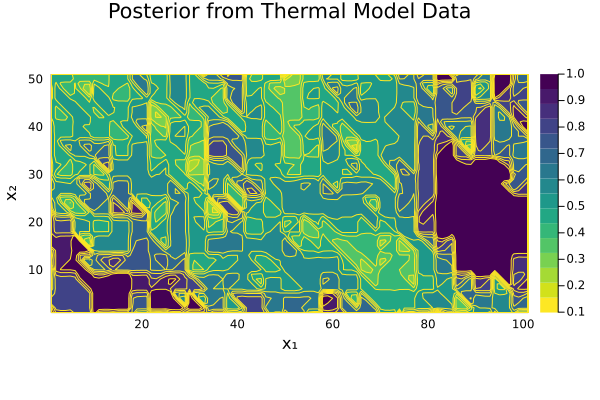

In [39]:
contourf(reshape(μₚ, (101,51))', title="Posterior from Thermal Model Data" ,colorbar = true, c = cgrad(:viridis, rev = true), xlims = (1, 101), ylims = (1, 51),legend = true,  xlabel = "x₁", ylabel = "x₂", aspectratio = :equal)

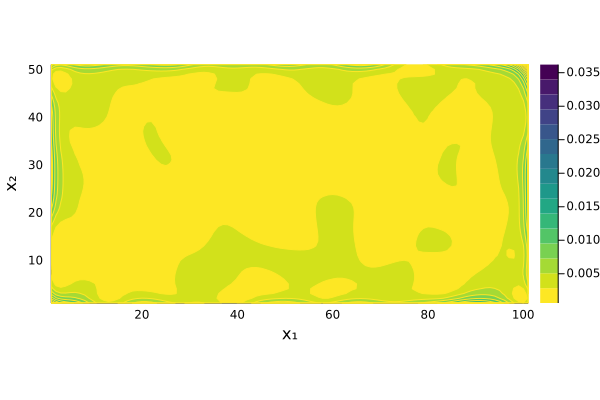

In [40]:
contourf(reshape(νₚ, (101,51))' ,colorbar = true, c = cgrad(:viridis, rev = true), xlims = (1, 101), ylims = (1, 51),legend = true,  xlabel = "x₁", ylabel = "x₂", aspectratio = :equal)

In [42]:
reshape(μ(GP.X, m)[1],5151)
#@time tmp = K(X, GP.X, k) / (K(GP.X, GP.X, k) + GP.ν*I)

5151-element reshape(extrapolate(scale(interpolate(::Matrix{Float64}, BSpline(Linear())), (1.0:1.0:101.0, 1.0:1.0:51.0)), Throw()), 5151) with eltype Float64:
 1.0
 0.8806897077897307
 0.866803997863737
 0.866803997863737
 0.8887769893949797
 0.8058594644083314
 0.7995880064087892
 0.7995880064087892
 0.7736934462500954
 1.0
 0.8438391699092088
 0.8258945601586938
 0.8258945601586938
 ⋮
 0.7574883649958037
 0.6830395971618219
 0.6397344930189974
 0.6369268329900053
 0.9428702220187686
 1.0
 1.0
 1.0
 0.8305943389028764
 0.6918593118181124
 0.683085374227512
 0.6825055313954376

In [44]:
length(X)

5151

In [10]:
KXX = K(X, X, k)
invKXX = inv(KXX)

x = 1:1:101
y = 1:1:51
X_eval = [[i,j] for i = 1:1:101, j = 1:1:51]
X_eval = reshape(X_eval, 5151)

@time f = rand(GP, X_eval)
# @time ν = [k(X[i], X[i]) - KXX[i,:]'*invKXX*KXX[i,:] for i in 1:length(X)]

  7.201355 seconds (126.77 M allocations: 5.652 GiB, 10.76% gc time, 1.20% compilation time)


5151-element Vector{Float64}:
 0.22399409124320668
 0.20154797538750535
 0.3003430414545287
 0.42134190419550654
 0.569516003051636
 0.6162153551065299
 0.7407343157443115
 0.8693663720555781
 0.9646803162176697
 1.3073364458945294
 1.25766433810074
 1.3369641183607022
 1.4247420449810413
 ⋮
 0.14583766736557602
 0.33478814065900064
 0.5565947251650079
 0.8096706269018275
 1.3570088004698098
 1.6291222827258542
 1.8140751404225304
 1.9603165079113078
 1.8962139769535873
 1.821951731864413
 1.8391432167122062
 1.826817163836996

In [12]:
μ_calc = μ(X_eval, GP.m)
Σ_calc = Σ(X_eval, GP.k)

  0.997507 seconds (506 allocations: 404.931 MiB, 0.26% compilation time)


41208

In [ ]:
@time rand(GP, μ_calc, Σ_calc)

In [14]:
itp(1.1,1.1)

0.984886854352636

In [15]:
GP = GaussianProcess(m, k, X, Nothing, Nothing)

1.0